In [1]:
import models.models_one_task as md_one
import datasets.iemocap as ds
from constants import *
from torchsummary import summary
import torch
import torch.nn as nn
import skorch
from skorch.helper import predefined_split
from skorch.dataset import Dataset
from skorch.classifier import NeuralNetClassifier
import skorch.callbacks as callbacks
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# Описание и демонстрация модулей

# Модуль models_one_task 

Модуль models_one_task на данный момент содержит PyTorch имплементацию следующих моделей для однозадачного обучения:

## AlexNet

[Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. <i>Commun. ACM</i> 60, 6 (June 2017), 84–90. DOI:https://doi.org/10.1145/3065386]

Архитектура немного переделана, чтобы соответствовать нашей специфике:<br>
1. Количество входных каналов первого сверточного слоя уменьшено с 3 до 1
2. Изменён последний свёрточный слой, его ядро увеличено с (3, 3) до (4, 4)
3. Изменён слой AdaptiveAvgPool2d с (6, 6) до (5, 5)
4. Изменён классификатор, теперь это четыре полносвязных слоя: 6400, 2048, 512, <число классов>
5. Добавлен Dropout() после первого и второго полносвязного слоя

In [2]:
model = md_one.alexnet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = model.to(device)
print(model)
summary(model, (1, 224, 224), batch_size=256)
model=None
torch.cuda.empty_cache()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
 

## VGG

[Simonyan, Karen & Zisserman, Andrew. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv 1409.1556. ]

Архитектура классификатора переделана в схожей с AlexNet манере.

In [3]:
# type - тип модели (11, 16, 19)
# bn - batch norm
model = md_one.vgg(num_classes=4, type=11, bn=False)
model = model.to(device)
print(model)
summary(model, (1, 224, 224), batch_size=64)
model=None
torch.cuda.empty_cache()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## SER DeepNet

[Anvarjon, T.; Mustaqeem; Kwon, S. Deep-Net: A Lightweight CNN-Based Speech Emotion Recognition System Using Deep Frequency Features. Sensors 2020, 20, 5212.]

У этой архитектуры заявлена точность на четырехклассовом IEMOCAP 77%. Отличается использованием свёртки с ядрами от (11,1) до (1,1), таким образом, свёртка спектрограммы происходит только по частотной оси. <br>
На вход подаются спектрограммы размерности 64х64

In [4]:
model = md_one.PaperCnnDeepNet(num_classes=4)
model = model.to(device)
print(model)
summary(model, (1, 64, 64), batch_size=64)

PaperCnnDeepNet(
  (features): Sequential(
    (0): Conv2d(1, 10, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
    (1): ReLU(inplace=True)
    (2): Conv2d(10, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (3): ReLU(inplace=True)
    (4): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (9): ReLU(inplace=True)
    (10): Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(20, 40, kernel_size=(13, 1), stride=(1, 1), padding=(6, 0))
    (15): Re

## SER StrideNet

[., Mustaqeem & Kwon, Soonil. (2019). A CNN-Assisted Enhanced Audio Signal Processing for Speech Emotion Recognition. Sensors. 20. 183. 10.3390/s20010183. ]

Ещё одна архитектура с высокой заявленной точностью.
Особенностью этой архитектуры является отсутствие Pooling слоёв: снижение размерности достигается использованием шага свёртки, равного двум. <br>
На вход подаются спектрограммы размером 128x128

In [14]:
model = md_one.PaperCnnStrideNet(num_classes=4)
model = model.to(device)
print(model)
summary(model, (1, 128, 128), batch_size=64)

PaperCnnStrideNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (13): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=True)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)


# Модуль iemocap

Данный модуль содержит классы IemocapDataset - датасет для нашей задачи. <br>
При инициализации экземпляра класса, производится попытка считать файл нужного исходя из указанных параметров датасета. 
Если попытка неудачна, будет начат процесс по составлению такого файла. За всеми подробностями добро пожаловать в 
datasets/datasets.py

## Датасет IEMOCAP

In [12]:
iemocap = ds.IemocapDataset(
    """
    Пути до файлов
    """
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    
    
    """    
    Параметры, по которым будет искаться .pkl-файл датасета. Изменение этих параметров у уже инициализированного экземпляра
    либо не приведет ни к какому результату, либо сломает программу, поэтому если их нужно поменять, то лучше инициализировать
    новый экземпляр
    
    base_name - идентификационное имя
    
    label_type - тип используемой разметки для IEMOCAP: 'four' - четыре класса (ang, hap, neu, sad), 'original' - все классы.
    mode - тренировочный или тестовый набор. Было заранее проведено разделение wav файлов на тренировочный и тестовый наборы
    (см. datasets/train_test_splits.py) c одинаковой взвешенностью эмоциональных классов.
    
    preprocessing - использовать или нет препроцессинг (удаление шума и тишины)
    
    spectrogram_shape - размер спектрограммы. Может быть каким угодно целым, но заранее заготовлены 64, 128 и 224.
    
    spectrogram_type - тип спектрограммы. Может быть 'spec' - обычная, и 'melspec' - мел-спектрограмма.
    """
    base_name='IEMOCAP', label_type='four', mode='train', preprocessing=False, spectrogram_shape=224, spectrogram_type='melspec',
    
    
    """    
    Параметры, влияющие на тип получаемых при индексации данных.
    Эти параметры можно менять у уже инициализированных экземпляров.
    
    augmentation - аугментация тренировочных данных. 
    Если спектрограмма слишком короткая, и augmentation=True, то она подается на функцию аугментации.
    Функция аугментации эту спектрограмму случайным образом может либо дополнить самой собой случайное количество раз 
    (чего может быть недостаточно, поэтому функция организована рекурсивно) либо окружить нулями. Процесс продолжается 
    до тех пор, пока спектрограмма не станет либо нужного размера, либо большего. Спектрограммы большего размера 
    случайно обрезаются. Важно заметить, что аугментации подвергаются только лишь тренировочные данные, тестовые же 
    спектрограммы, если они слишком короткие, обрабатываются одинаково (с фиксированным случайным зерном) в зависимости 
    от значения параметра padding.
    
    padding - обработка слишком коротких спектрограмм.
    Подобным образом обрабатываются все тестовые экземпляры (с фиксированным зерном), а также можно таким образом обработать
    и тренировочные экземпляры (с не фиксированным зерном), если augmentation=False. 
    Возможные варианты: 'zero' - окружить нулями до нужного размера, 'repeat' - повторить саму себя столько раз, 
    сколько необходимо для достижения нужного или большего размера, затем обрезать.
    
    tasks - список задач (tuple). Доступны: 
    emotion; (emotion, speaker); (emotion, gender); (emotion, speaker, gender); (valence, arousal, dominance) 
    """
    augmentation=False, padding='repeat', tasks='emotion' 
)

SyntaxError: invalid syntax (<ipython-input-12-924d8a06020c>, line 5)

### Заранее готовы следующие варианты датасета IEMOCAP:

#### Разметка на 4 эмоциональные категории:

Размер спектрограммы 64х64, с препроцессингом и без, тренировочный и тестовый наборы

In [5]:
iemocap_64_noprep_train = ds.IemocapDataset(  # Без препроцессинга, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=64, spectrogram_type='melspec', tasks='emotion'
)
iemocap_64_noprep_test = ds.IemocapDataset(  # Без препроцессинга, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=64, spectrogram_type='melspec', tasks='emotion'
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_64_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_64_test ===============
=========================== SUCCESS! ====================================


In [2]:
iemocap_64_prep_train = ds.IemocapDataset(  # C препроцессингом, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=64, spectrogram_type='melspec', tasks='emotion' 
)
iemocap_64_prep_test = ds.IemocapDataset(  # С препроцессингом, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=64, spectrogram_type='melspec', tasks='emotion' 
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_64_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_64_test ===============
=========================== SUCCESS! ====================================


Размер спектрограммы 128х128, с препроцессингом и без, тренировочный и тестовый наборы

In [2]:
iemocap_128_noprep_train = ds.IemocapDataset(  # Без препроцессинга, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=128, spectrogram_type='melspec', tasks='emotion' 
)
iemocap_128_noprep_test = ds.IemocapDataset(  # Без препроцессинга, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=128, spectrogram_type='melspec', tasks='emotion' 
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_128_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_128_test ===============
=========================== SUCCESS! ====================================


In [4]:
iemocap_128_prep_train = ds.IemocapDataset(  # C препроцессингом, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=128, spectrogram_type='melspec', tasks='emotion' 
)
iemocap_128_prep_test = ds.IemocapDataset(  # С препроцессингом, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=128, spectrogram_type='melspec', tasks='emotion' 
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_128_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_128_test ===============
=========================== SUCCESS! ====================================


Размер спектрограммы 224х224, с препроцессингом и без, тренировочный и тестовый наборы

In [2]:
iemocap_224_noprep_train = ds.IemocapDataset(  # Без препроцессинга, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion'
)
iemocap_224_noprep_test = ds.IemocapDataset(  # Без препроцессинга, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion'
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_224_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_224_test ===============
=========================== SUCCESS! ====================================


In [2]:
iemocap_224_prep_train = ds.IemocapDataset(  # C препроцессингом, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion'
)
iemocap_224_prep_test = ds.IemocapDataset(  # С препроцессингом, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion' 
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_224_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_224_test ===============
=========================== SUCCESS! ====================================


### Метод show_image() позволяет взглянуть, какие спектрограммы выдает датасет в текущей конфигурации. 
#### Возвращает ax - объект Axes. Продемонстрирую с его помощью, как работает аугментация данных на примере тренировочного набора без препроцессинга с четырьмя категориями. Будет выведена четыре раза одна спектрограмма.

In [6]:
img, label = iemocap_224_noprep_train[0]
print(img.shape)

torch.Size([1, 224, 224])


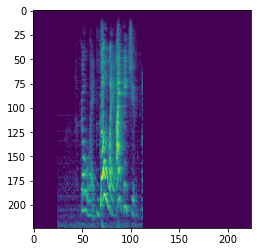

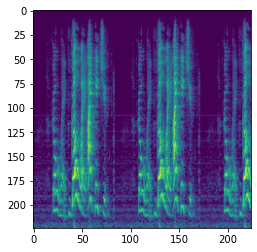

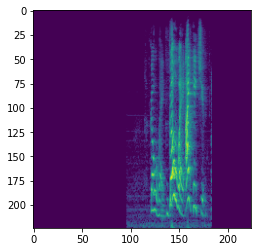

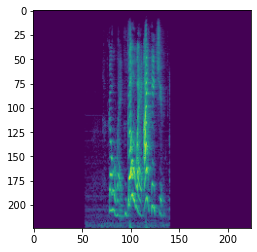

In [12]:
iemocap_224_noprep_train.augmentation = True
np.random.seed()
n = np.random.randint(1, len(iemocap_224_noprep_train))
for i in np.arange(1, 5):
        ax = iemocap_224_noprep_train.show_image(n)
        plt.show()

#### Тестовые спектрограммы ведут себя иначе, они всегда одинаковы
#### Однако, заранее нужно указать для всех будущих спектрограмм тип пэддигна, это небольшой минус

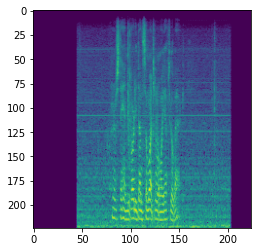

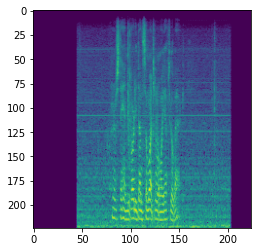

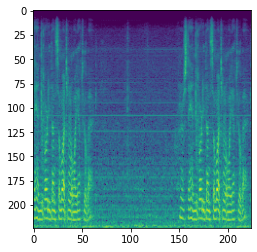

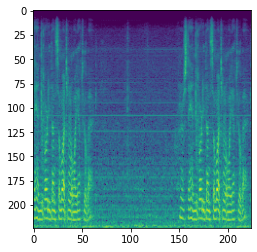

In [13]:
iemocap_224_noprep_test.padding = 'zero'  
np.random.seed()
n = np.random.randint(1, len(iemocap_224_noprep_test))
for i in np.arange(1, 3):
        ax = iemocap_224_noprep_test.show_image(n)
        plt.show()
iemocap_224_noprep_test.padding = 'repeat'
for i in np.arange(1, 3):
        ax = iemocap_224_noprep_test.show_image(n)
        plt.show()

#### Также взглянем на результат препроцессинга

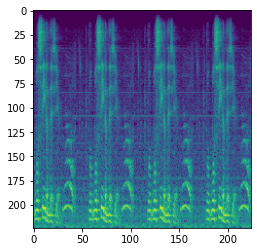

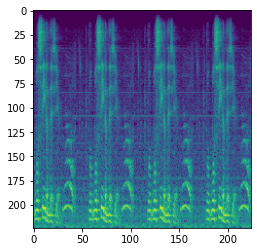

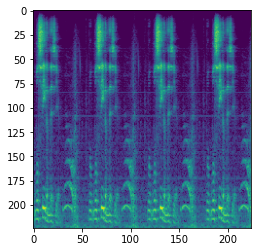

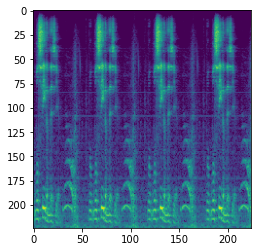

In [17]:
np.random.seed()
n = np.random.randint(1, len(iemocap_224_prep_test))
iemocap_224_prep_test.padding = 'repeat'
iemocap_224_noprep_test.padding = 'repeat'
for i in np.arange(1, 3):
        ax = iemocap_224_noprep_test.show_image(n)
        plt.show()
for i in np.arange(1, 3):
        ax = iemocap_224_prep_test.show_image(n)
        plt.show()

# It's learning time!

## 1. Однозадачное обучение

### 1.1. Без препроцессинга и аугментации

#### AlexNet

In [3]:
# Готовим датасеты, необходим размер 224х224
train_dataset = iemocap_224_noprep_train
test_dataset = iemocap_224_noprep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [3]:
# Готовим колбэки и девайсы
filename = 'AlexNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_acc', patience=10, 
                                              threshold_mode='rel', lower_is_better=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

NameError: name 'train_dataset' is not defined

In [5]:
# Используем для обучения и сохранения моделей модуль Skorch [https://skorch.readthedocs.io/en/stable/index.html]
model = md_one.alexnet(num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.001, max_epochs=100, batch_size=64, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [7]:
print(filename)
net.fit(train_dataset, y=None)

AlexNet--IEMOCAP-4_four_prep-false_224_train_augmentation-false.md
  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.3595        1.3564       0.3807        1.3227     +  17.6988
      2       0.3973        1.3058       0.4244        1.2296     +  17.5615
      3       0.4840        1.1631       0.5666        1.0481     +  17.5884
      4       0.5392        1.1026       0.5050        1.1054        17.4429
      5       0.5619        1.0736       0.5789        1.0181     +  17.4817
      6       0.5733        1.0501       0.5465        1.0734        17.6426
      7       0.5787        1.0387       0.5946        1.0056     +  17.5964
      8       0.5918        1.0095       0.6047        0.9703     +  17.4764
      9       0.6145        0.9941       0.6137        0.9537     +  17.7253
     10       0.6055        0.9965       0.6282        0.9484     +  17.7865
     11  

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

#### VGG-11 с батч-нормализацией

In [6]:
filename = 'VGGNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)

In [7]:
model = md_one.vgg(type=11, bn=True, num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.001, max_epochs=100, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [10]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.4793        1.3555       0.5857        0.9952     +  38.5105
      2       0.5753        1.0323       0.5767        1.0507        38.2903
      3       0.5759        1.0570       0.4692        1.1855        38.1377
      4       0.5882        1.0370       0.5140        1.3185        38.1817
      5       0.5857        1.0396       0.5868        1.3585     +  38.2436
      6       0.5943        1.0200       0.5924        0.9847     +  38.2340
      7       0.6053        0.9991       0.6338        0.9510     +  38.2368
      8       0.6083        0.9894       0.5845        0.9899        38.3147
      9       0.6089        0.9814       0.6114        0.9580        38.4050
     10       0.6207        0.9724       0.5745        0.9956        38.5623
     11       0.6237        0.9662       0.5106        1.2096        38.6954

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, mome

#### SER DeepNet

In [3]:
train_dataset = iemocap_64_noprep_train
test_dataset = iemocap_64_noprep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [4]:
filename = 'DeepNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)

In [10]:
model = md_one.PaperCnnDeepNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.0001, max_epochs=100, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [11]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.4810        1.1742       0.5465        1.0680     +  3.1173
      2       0.5672        1.0381       0.6137        0.9717     +  3.1411
      3       0.5817        1.0022       0.5980        0.9854        3.1407
      4       0.5997        0.9870       0.6125        0.9565        3.1162
      5       0.6005        0.9791       0.6025        0.9723        3.1199
      6       0.5974        0.9672       0.6069        0.9530        3.1061
      7       0.5938        0.9585       0.6204        0.9221     +  3.1154
      8       0.6027        0.9447       0.6159        0.9248        3.1632
      9       0.6114        0.9341       0.6181        0.9275        3.1100
     10       0.6064        0.9252       0.6069        0.9466        3.1121
     11       0.6153        0.9279       0.6170        0.9384        3.1135
     12     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnDeepNet(
    (features): Sequential(
      (0): Conv2d(1, 10, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (1): ReLU(inplace=True)
      (2): Conv2d(10, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (3): ReLU(inplace=True)
      (4): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (9): ReLU(inplace=True)
      (10): Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running

#### SER StrideNet

In [3]:
train_dataset = iemocap_128_noprep_train
test_dataset = iemocap_128_noprep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [7]:
# Готовим колбэки и девайсы
filename = 'StrideNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_acc', patience=15, 
                                              threshold_mode='rel', lower_is_better=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [8]:
model = md_one.PaperCnnStrideNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.0001, max_epochs=100, batch_size=64, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [9]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3485        1.3538       0.3807        1.3209     +  4.7159
      2       0.3813        1.3187       0.3807        1.3008        4.9668
      3       0.4759        1.1843       0.5386        1.0420     +  4.9531
      4       0.5638        1.0728       0.5789        1.0267     +  4.8103
      5       0.5663        1.0485       0.5969        0.9962     +  4.7933
      6       0.5733        1.0414       0.5879        1.0039        4.9067
      7       0.5873        1.0175       0.5991        0.9873     +  4.8180
      8       0.5823        1.0142       0.6002        0.9592     +  5.1353
      9       0.5879        1.0097       0.6069        0.9625     +  4.9314
     10       0.5988        0.9876       0.5991        0.9527        5.0139
     11       0.5935        0.9894       0.6125        0.9447     +  4.9044
     12     

     94       0.7326        0.6916       0.6506        0.8733        4.7368
     95       0.7242        0.6903       0.6529        0.8835        4.8479
     96       0.7374        0.6817       0.6439        0.9089        4.7387
     97       0.7293        0.6850       0.6417        0.8995        4.7074
     98       0.7324        0.6828       0.6663        0.8842        4.7241
     99       0.7357        0.6775       0.6495        0.8886        4.7288
    100       0.7466        0.6744       0.6517        0.8880        4.7454


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnStrideNet(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (11): ReLU(inplace=True)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (13): ReLU(inplace=True)
    )
    (classifier): Sequential(
      (0): Linear(in_features=1152, out_features=512, bias=True)
      (1): ReLU(inplace=T

### 1.2. Подрубаем препроцессинг

#### AlexNet

In [3]:
train_dataset = iemocap_224_prep_train
test_dataset = iemocap_224_prep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [9]:
filename = 'AlexNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=10, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [11]:
model = md_one.alexnet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.001, max_epochs=100, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [12]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.4012        1.2987       0.4894        1.1092     +  18.1668
      2       0.5039        1.1370       0.5610        1.1395     +  18.1835
      3       0.5501        1.0867       0.5845        0.9979     +  18.3484
      4       0.5644        1.0675       0.6047        1.0002     +  18.2334
      5       0.5787        1.0515       0.5745        1.0872        18.1874
      6       0.5899        1.0242       0.6069        0.9610     +  18.2211
      7       0.6022        1.0180       0.6338        0.9402     +  18.2982
      8       0.6187        0.9851       0.6372        0.9252     +  18.3291
      9       0.5829        1.0064       0.6181        0.9478        18.3212
     10       0.6109        0.9855       0.6215        0.9439        18.3423
     11       0.6179        0.9629       0.6293        0.9337        18.2646

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

#### VGG

In [14]:
filename = 'VggNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=10, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [15]:
model = md_one.vgg(type=11, bn=True, num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.001, max_epochs=100, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [16]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.4938        1.3577       0.4670        1.1938     +  37.6703
      2       0.5591        1.0669       0.5655        1.0213     +  37.6653
      3       0.5680        1.0647       0.5308        1.0255        37.8577
      4       0.5739        1.0407       0.5644        1.0865        37.6432
      5       0.5946        1.0262       0.5106        1.1431        37.7263
      6       0.5966        1.0308       0.6349        0.9371     +  37.8122
      7       0.5985        1.0108       0.5935        0.9807        37.8353
      8       0.6145        1.0050       0.6293        0.9378        37.7936
      9       0.6204        0.9799       0.5969        1.0238        38.0119
     10       0.6165        0.9764       0.6361        0.9446     +  37.9260
     11       0.6313        0.9571       0.6383        0.9467     +  38.0982

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, mome

#### DeepNet

In [3]:
train_dataset = iemocap_64_prep_train
test_dataset = iemocap_64_prep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [15]:
filename = 'DeepNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [18]:
model = md_one.PaperCnnDeepNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.0001, max_epochs=100, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [19]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.5006        1.1570       0.5442        1.0764     +  3.0891
      2       0.5546        1.0534       0.5812        1.0112     +  3.1057
      3       0.5745        1.0260       0.5812        0.9933        3.1122
      4       0.5896        0.9993       0.6081        0.9678     +  3.0817
      5       0.5941        0.9860       0.6125        0.9608     +  3.0997
      6       0.5969        0.9715       0.6058        0.9647        3.1020
      7       0.6109        0.9634       0.6047        0.9488        3.1222
      8       0.6055        0.9596       0.6092        0.9439        3.1108
      9       0.6120        0.9421       0.6114        0.9462        3.1075
     10       0.6092        0.9430       0.6159        0.9344     +  3.1098
     11       0.6190        0.9233       0.6193        0.9375     +  3.1226
     12     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnDeepNet(
    (features): Sequential(
      (0): Conv2d(1, 10, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (1): ReLU(inplace=True)
      (2): Conv2d(10, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (3): ReLU(inplace=True)
      (4): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (9): ReLU(inplace=True)
      (10): Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running

#### StrideNet

In [5]:
train_dataset = iemocap_128_prep_train
test_dataset = iemocap_128_prep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [11]:
filename = 'StrideNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [12]:
model = md_one.PaperCnnStrideNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.0001, max_epochs=150, batch_size=64, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [13]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3813        1.3439       0.3807        1.3153     +  4.7218
      2       0.4577        1.2191       0.5230        1.0859     +  4.7153
      3       0.5361        1.0937       0.5610        1.0614     +  4.7308
      4       0.5557        1.0810       0.5689        1.0371     +  4.7525
      5       0.5563        1.0697       0.5745        1.0327     +  4.7406
      6       0.5728        1.0525       0.5733        1.0160        4.7137
      7       0.5798        1.0382       0.6002        1.0004     +  4.7229
      8       0.5929        1.0168       0.6036        1.0076     +  4.7085
      9       0.5988        0.9972       0.5991        0.9847        4.7759
     10       0.5915        0.9983       0.6159        0.9654     +  4.7432
     11       0.6128        0.9775       0.6271        0.9560     +  4.7374
     12     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnStrideNet(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (11): ReLU(inplace=True)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (13): ReLU(inplace=True)
    )
    (classifier): Sequential(
      (0): Linear(in_features=1152, out_features=512, bias=True)
      (1): ReLU(inplace=T

### 1.3. Подрубаем data augmentation (без препроцессинга)

#### AlexNet

In [12]:
train_dataset = iemocap_224_noprep_train
test_dataset = iemocap_224_noprep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [13]:
filename = 'AlexNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [14]:
model = md_one.alexnet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.001, max_epochs=100, batch_size=64, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [15]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.3541        1.3450       0.4513        1.2815     +  15.9470
      2       0.4174        1.2622       0.4670        1.1570     +  15.9089
      3       0.5050        1.1424       0.5554        1.0754     +  16.0539
      4       0.5316        1.1225       0.5767        1.0401     +  15.9796
      5       0.5655        1.0722       0.5890        1.0009     +  15.8380
      6       0.5946        1.0247       0.6260        0.9459     +  15.9698
      7       0.5862        1.0182       0.6058        0.9845        15.8240
      8       0.6030        0.9978       0.6025        0.9855        15.8510
      9       0.5971        1.0014       0.6002        0.9740        16.4618
     10       0.6106        0.9897       0.6114        0.9659        15.7746
     11       0.6137        0.9758       0.6260        0.9300        16.5103

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

#### VGG

In [3]:
train_dataset = iemocap_224_noprep_train
test_dataset = iemocap_224_noprep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [4]:
filename = 'VggNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=10, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [5]:
model = md_one.vgg(type=11, bn=True, num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.001, max_epochs=100, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [6]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.4852        1.4482       0.5532        1.0836     +  40.4857
      2       0.5501        1.0726       0.6047        1.0046     +  38.2336
      3       0.5675        1.0565       0.3807        2.0127        44.8862
      4       0.5829        1.0278       0.4580        1.2268        38.6756
      5       0.6005        1.0102       0.3617        2.4584        45.9794
      6       0.5829        1.0149       0.5913        1.0045        54.3793
      7       0.5985        1.0071       0.6193        0.9361     +  38.4190
      8       0.6176        0.9899       0.6260        0.9469     +  38.7492
      9       0.6176        0.9768       0.5689        1.0999        38.3753
     10       0.6156        0.9729       0.5241        1.2444        38.8273
     11       0.6226        0.9645       0.5342        0.9935        39.7004

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, mome

#### DeepNet

In [6]:
train_dataset = iemocap_64_noprep_train
test_dataset = iemocap_64_noprep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [7]:
filename = 'DeepNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [8]:
model = md_one.PaperCnnDeepNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.0001, max_epochs=100, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [9]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.4731        1.1778       0.5689        1.0316     +  3.2492
      2       0.5594        1.0532       0.6047        0.9828     +  3.1224
      3       0.5823        1.0146       0.5991        0.9765        3.1160
      4       0.5977        0.9899       0.6081        0.9635     +  3.0982
      5       0.5980        0.9747       0.5879        0.9887        3.1165
      6       0.6064        0.9611       0.6159        0.9561     +  3.0991
      7       0.6075        0.9565       0.6114        0.9551        3.1136
      8       0.6120        0.9473       0.6114        0.9401        3.1128
      9       0.6095        0.9378       0.6058        0.9400        3.0963
     10       0.6170        0.9272       0.6148        0.9381        3.0959
     11       0.6176        0.9318       0.6114        0.9408        3.0986
     12     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnDeepNet(
    (features): Sequential(
      (0): Conv2d(1, 10, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (1): ReLU(inplace=True)
      (2): Conv2d(10, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (3): ReLU(inplace=True)
      (4): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (9): ReLU(inplace=True)
      (10): Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running

#### StrideNet

In [3]:
train_dataset = iemocap_128_noprep_train
test_dataset = iemocap_128_noprep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [4]:
filename = 'StrideNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [5]:
model = md_one.PaperCnnStrideNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.0001, max_epochs=150, batch_size=64, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [6]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3469        1.3513       0.3807        1.3269     +  4.9778
      2       0.3813        1.3210       0.3807        1.3132        4.7214
      3       0.4149        1.2768       0.5151        1.1574     +  4.7953
      4       0.5302        1.1042       0.5767        1.0263     +  4.6296
      5       0.5557        1.0494       0.5431        1.0679        4.7443
      6       0.5697        1.0365       0.5845        0.9958     +  4.7272
      7       0.5714        1.0340       0.5857        0.9981     +  4.7465
      8       0.5703        1.0201       0.5924        0.9702     +  4.7210
      9       0.5787        1.0079       0.5991        0.9690     +  4.6964
     10       0.5851        0.9933       0.6058        0.9605     +  4.7879
     11       0.5963        0.9881       0.6047        0.9498        4.6908
     12     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnStrideNet(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (11): ReLU(inplace=True)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (13): ReLU(inplace=True)
    )
    (classifier): Sequential(
      (0): Linear(in_features=1152, out_features=512, bias=True)
      (1): ReLU(inplace=T